MAP fitter for RFI time series. Heavily WIP.

In [381]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from SSINS import INS
import os
import scipy.linalg as la
from scipy.signal.windows import dpss
from scipy.optimize import minimize
import corner


In [382]:
##Defining two important functions -- the frequency channel selection and averaging functions.

def chan_select(ins, chan_name, shape_dict):

    """
    The frequency channel selection function. Also used to apply masks to your data.

    Args
    -----
    ins:
        INS object to be filtered.
    chan_name:
        channel name from shape dictionary
    shape_dict:
        shape dictionary by which you've divided and labelled the frequency array

    Returns
    -------
    ins_subband:
        INS object whose metric array is the filtered metric array without masks.
    masked_ins:
        INS object whose metric array is the filtered metric array with masks.
    N_bl:
        number of baselines.
    N_freq:
        number of frequencies.
    """

    #Creating band selection mask
    freq_mask = (ins.freq_array >= shape_dict[chan_name][0]) & (ins.freq_array <= shape_dict[chan_name][1])
    subband_chans = np.where(freq_mask)[0]
    N_freq = len(subband_chans)

    #Generating selected subband array
    ins_subband = ins.copy()
    ins_subband.select(freq_chans=subband_chans)
    N_bl = np.max(ins_subband.weights_array)

    #Masking
    masked_ins = ins_subband.copy()
    mask_array = ins_subband.mask_to_flags()[1:]
    masked_data = np.copy(ins_subband.metric_array)
    masked_data[mask_array] = np.nan
    masked_ins.metric_array = masked_data
    
    #Getting rid of the pesky subband lines
    line_mask = np.load('linemask.npy')[subband_chans]
    ins_subband.metric_array = ins_subband.metric_array[:, ~line_mask, :]
    ins_subband.freq_array = ins_subband.freq_array[~line_mask]
    masked_ins.metric_array = masked_ins.metric_array[:, ~line_mask, :]
    masked_ins.freq_array = masked_ins.freq_array[~line_mask]

    return ins_subband, masked_ins, N_bl, N_freq


def chan_avg(ins):

    """
    The frequency channel averaging function. Averages the metric array over the frequency axis.

    Args
    ----
    ins:
        INS object to be averaged.

    Returns
    -------
    time_filtered:
        Clean time series.
    freq_averaged:
        Clean and frequency-averaged metric array.
    """
    
    #Calling time and amplitudes, filtering out infs and NaNs by mapping them to -1.
    time = np.array(ins.time_array)
    data = np.array(ins.metric_array[:, :, 0])
    data[~np.isfinite(data)] = -1

    #Averaging over full band/subband per integration
    freq_averaged = np.mean(data, axis=1)

    #Filtering out zeroes
    non_zero_mask = freq_averaged > 0
    time_filtered = time[non_zero_mask]
    freq_averaged = freq_averaged[non_zero_mask]

    return time_filtered, freq_averaged



In [383]:

data_dir = "Data"
night = "109337_p2"

datapath = os.path.join(data_dir, night + "_SSINS_data.h5")

ins = INS(datapath, telescope_name='MWA')

#Shape dictionary
TV_dict = {
    'TV6': [1.74e8, 1.81e8],
    'TV7': [1.81e8, 1.88e8],
    'TV8': [1.88e8, 1.95e8],
    'TV9': [1.95e8, 2.02e8]
    }

##Selecting one DTV subband
chan_name = 'TV7'

##Extracting and averaging over the selected subband
ins_subband, masked_ins, N_bl, N_freq = chan_select(ins, chan_name, TV_dict)
time, amp = chan_avg(ins_subband)
masked_time, masked_amp = chan_avg(masked_ins)

invalid value encountered in multiply
invalid value encountered in divide
sig_array has been reset


In [384]:
#Peaks, amplitudes (arb units)
peaks=np.array([53.35432366, 8.97030183, 39.32910956, 28.3103236, 30.93772398, 36.2624972, 15.55913153, 44.21889192,
       44.9823896, 36.18116225, 25.08418434, 33.37233714, 51.98871383, 71.11015838, 25.76393398, 17.09304232, 
       6.0885566, 11.14962293, 52.29949963, 44.91604231, 23.85311619, 57.59864797, 1.21500878e+01, 4.57578285e+01,
       43.16161392, 51.0379999, 16.44774823, 53.31619823, 85.09920858, 10.72147938, 18.26272233, 37.61133042,
       11.1810082, 12.82857739, 51.49711535, 20.3400262, 34.50876787, 46.37546283, 35.81477314, 36.96341681,
       9.18631159, 33.3049884, 6.10809826, 18.75778949, 26.21931248, 46.57467886, 22.82709187, 18.69584422,
       56.140001, 66.05041274, 61.65063534, 5.5279846, 7.64796047, 59.34091678, 63.71339591, 38.23994538])


#Time into pointing/length of pointing -- want flat
loc=np.array([0.39361857, 0.94595976, 0.52309947, 0.1174075, 0.42087645, 0.55030397, 0.96448721, 0.95354939,
     0.5667833, 0.9647058, 0.13256501, 0.52036559, 0.18725956, 0.53959978, 0.81926798, 0.85710116, 
     0.19789189, 0.56327705, 0.62144842, 0.11526984, 0.44578389, 0.15972674, 1.84629939e-01, 8.81903585e-01,
     2.53746154e-01, 3.52378053e-01, 6.56658287e-01, 0.20640947, 0.9842502, 0.82448753, 0.79864468, 0.82609582,
     0.11022169, 0.07753185, 0.57244621, 0.0896191, 0.64090821, 0.4027631, 0.24795562, 0.72001842,
     0.10122139, 0.25738608, 0.64577568, 0.68554986, 0.45178244, 0.82402821, 0.16167855, 0.25189232,
     0.45948544, 0.53000544, 0.94603795, 0.41958575, 0.94060631, 0.4551634, 0.96417559, 0.68670813])

#Durations (s)
widths=np.array([46.35740966, 47.78082138, 52.01985143, 51.1243677, 48.66579981, 62.63576724, 51.55184647, 64.54810228,
        68.97618067, 63.08569669, 56.8891352, 64.68566024, 54.74073774, 57.955234, 35.92143505, 32.08070818,
        74.16922759, 57.12015228, 69.59804093, 65.70437593, 47.97567077, 82.01174163, 6.44723034e+01, 6.44048269e+01,
        6.87384350e+01, 6.99024843e+01, 5.66360677e+01, 73.41190595, 97.88771772, 38.34149624, 40.48260042, 62.84866352,
        39.34094184, 43.88357933, 68.20029216, 55.17499495, 59.64828645, 65.16642306, 59.59367969, 57.69014685,
        39.30030286, 25.61981977, 60.45653745, 36.25104968, 50.26782436, 66.64052355, 64.69421242, 35.47301949,
        57.35702717, 62.72083288, 57.83072425, 72.39670654, 7.68408292e+01, 56.47607773, 58.60065642, 58.92762818])

widths = np.sort(widths)/60/60/24
loc = np.sort(loc)
peaks = np.sort(peaks)

In [385]:
theta_0 = np.vstack((peaks, loc*(np.max(time) - np.min(time)), widths))
print(np.cov(theta_0[[0, 2]]))
emit_cov = la.block_diag(*[np.cov(theta_0[[0, 2]])] * 3)
print(emit_cov)

[[3.71570859e+02 2.87351789e-03]
 [2.87351789e-03 2.37580341e-08]]
[[3.71570859e+02 2.87351789e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.87351789e-03 2.37580341e-08 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.71570859e+02 2.87351789e-03
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.87351789e-03 2.37580341e-08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.71570859e+02 2.87351789e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.87351789e-03 2.37580341e-08]]


In [386]:
def DPSS_fit(time, masked_time, masked_amp, N_win=4, N_terms=13, N_bl=N_bl, N_freq=N_freq):
    
    '''The DPSS basis fitting function. Used to fit smooth background to masked data.

    Args:
        time            -- Numpy unmasked time array.
        masked_time     -- Numpy masked time array.
        masked_amp      -- Numpy masked visibility amplitudes array.
        N_win           -- Half-bandwidth in the DPSS basis. See scipy.signal.windows.dpss for documentation.
        N_terms         -- Number of terms you want in the DPSS basis.
        N_bl            -- Number of baselines you're averaging over.
        N_freq          -- Number of frequency bins you're averaging over. '''

    #Sorting indices in case they got messed up somewhere.
    sort_ind = np.argsort(masked_time)
    masked_time = np.array(masked_time[sort_ind])
    masked_amp = np.array(masked_amp[sort_ind])

    #Generating uniform time grid
    dt = st.mode(np.diff(masked_time)).mode
    smooth_time = np.arange(time.min(), time.max() + dt, dt)

    #Padding amplitude arrays with NaN
    masked_padded_amp = np.full_like(smooth_time, np.nan, dtype=float)
    masked_indices = np.searchsorted(smooth_time, masked_time)
    masked_padded_amp[masked_indices] = masked_amp

    #Generating DPSS design matrix
    M = len(smooth_time)
    design = dpss(M, N_win, Kmax=N_terms, return_ratios=True)[0].T

    #Constructing least-squares DPSS coefficients
    observed_indices = ~np.isnan(masked_padded_amp)
    splice_design = design[observed_indices, :]
    coefficients = la.solve(splice_design.T @ splice_design, splice_design.T @ masked_padded_amp[observed_indices])
    fit = design @ coefficients     #Main return of the DPSS_fit function
    
    #Finding the noise covariances
    mu = splice_design @ coefficients
    C = 4/np.pi-1
    noise_cov = np.diag((fit ** 2) * C / (N_bl * N_freq))
    splice_noise_cov = np.diag((mu ** 2) * C / (N_bl * N_freq))

    #Finding the parameter covariance
    sigma_p = la.solve(splice_design.T @ la.solve(splice_noise_cov, splice_design), np.eye(splice_design.shape[1]))

    #Finding the fit covariance
    sigma_f = design @ sigma_p @ design.T

    return fit, coefficients, smooth_time, noise_cov, sigma_p, sigma_f

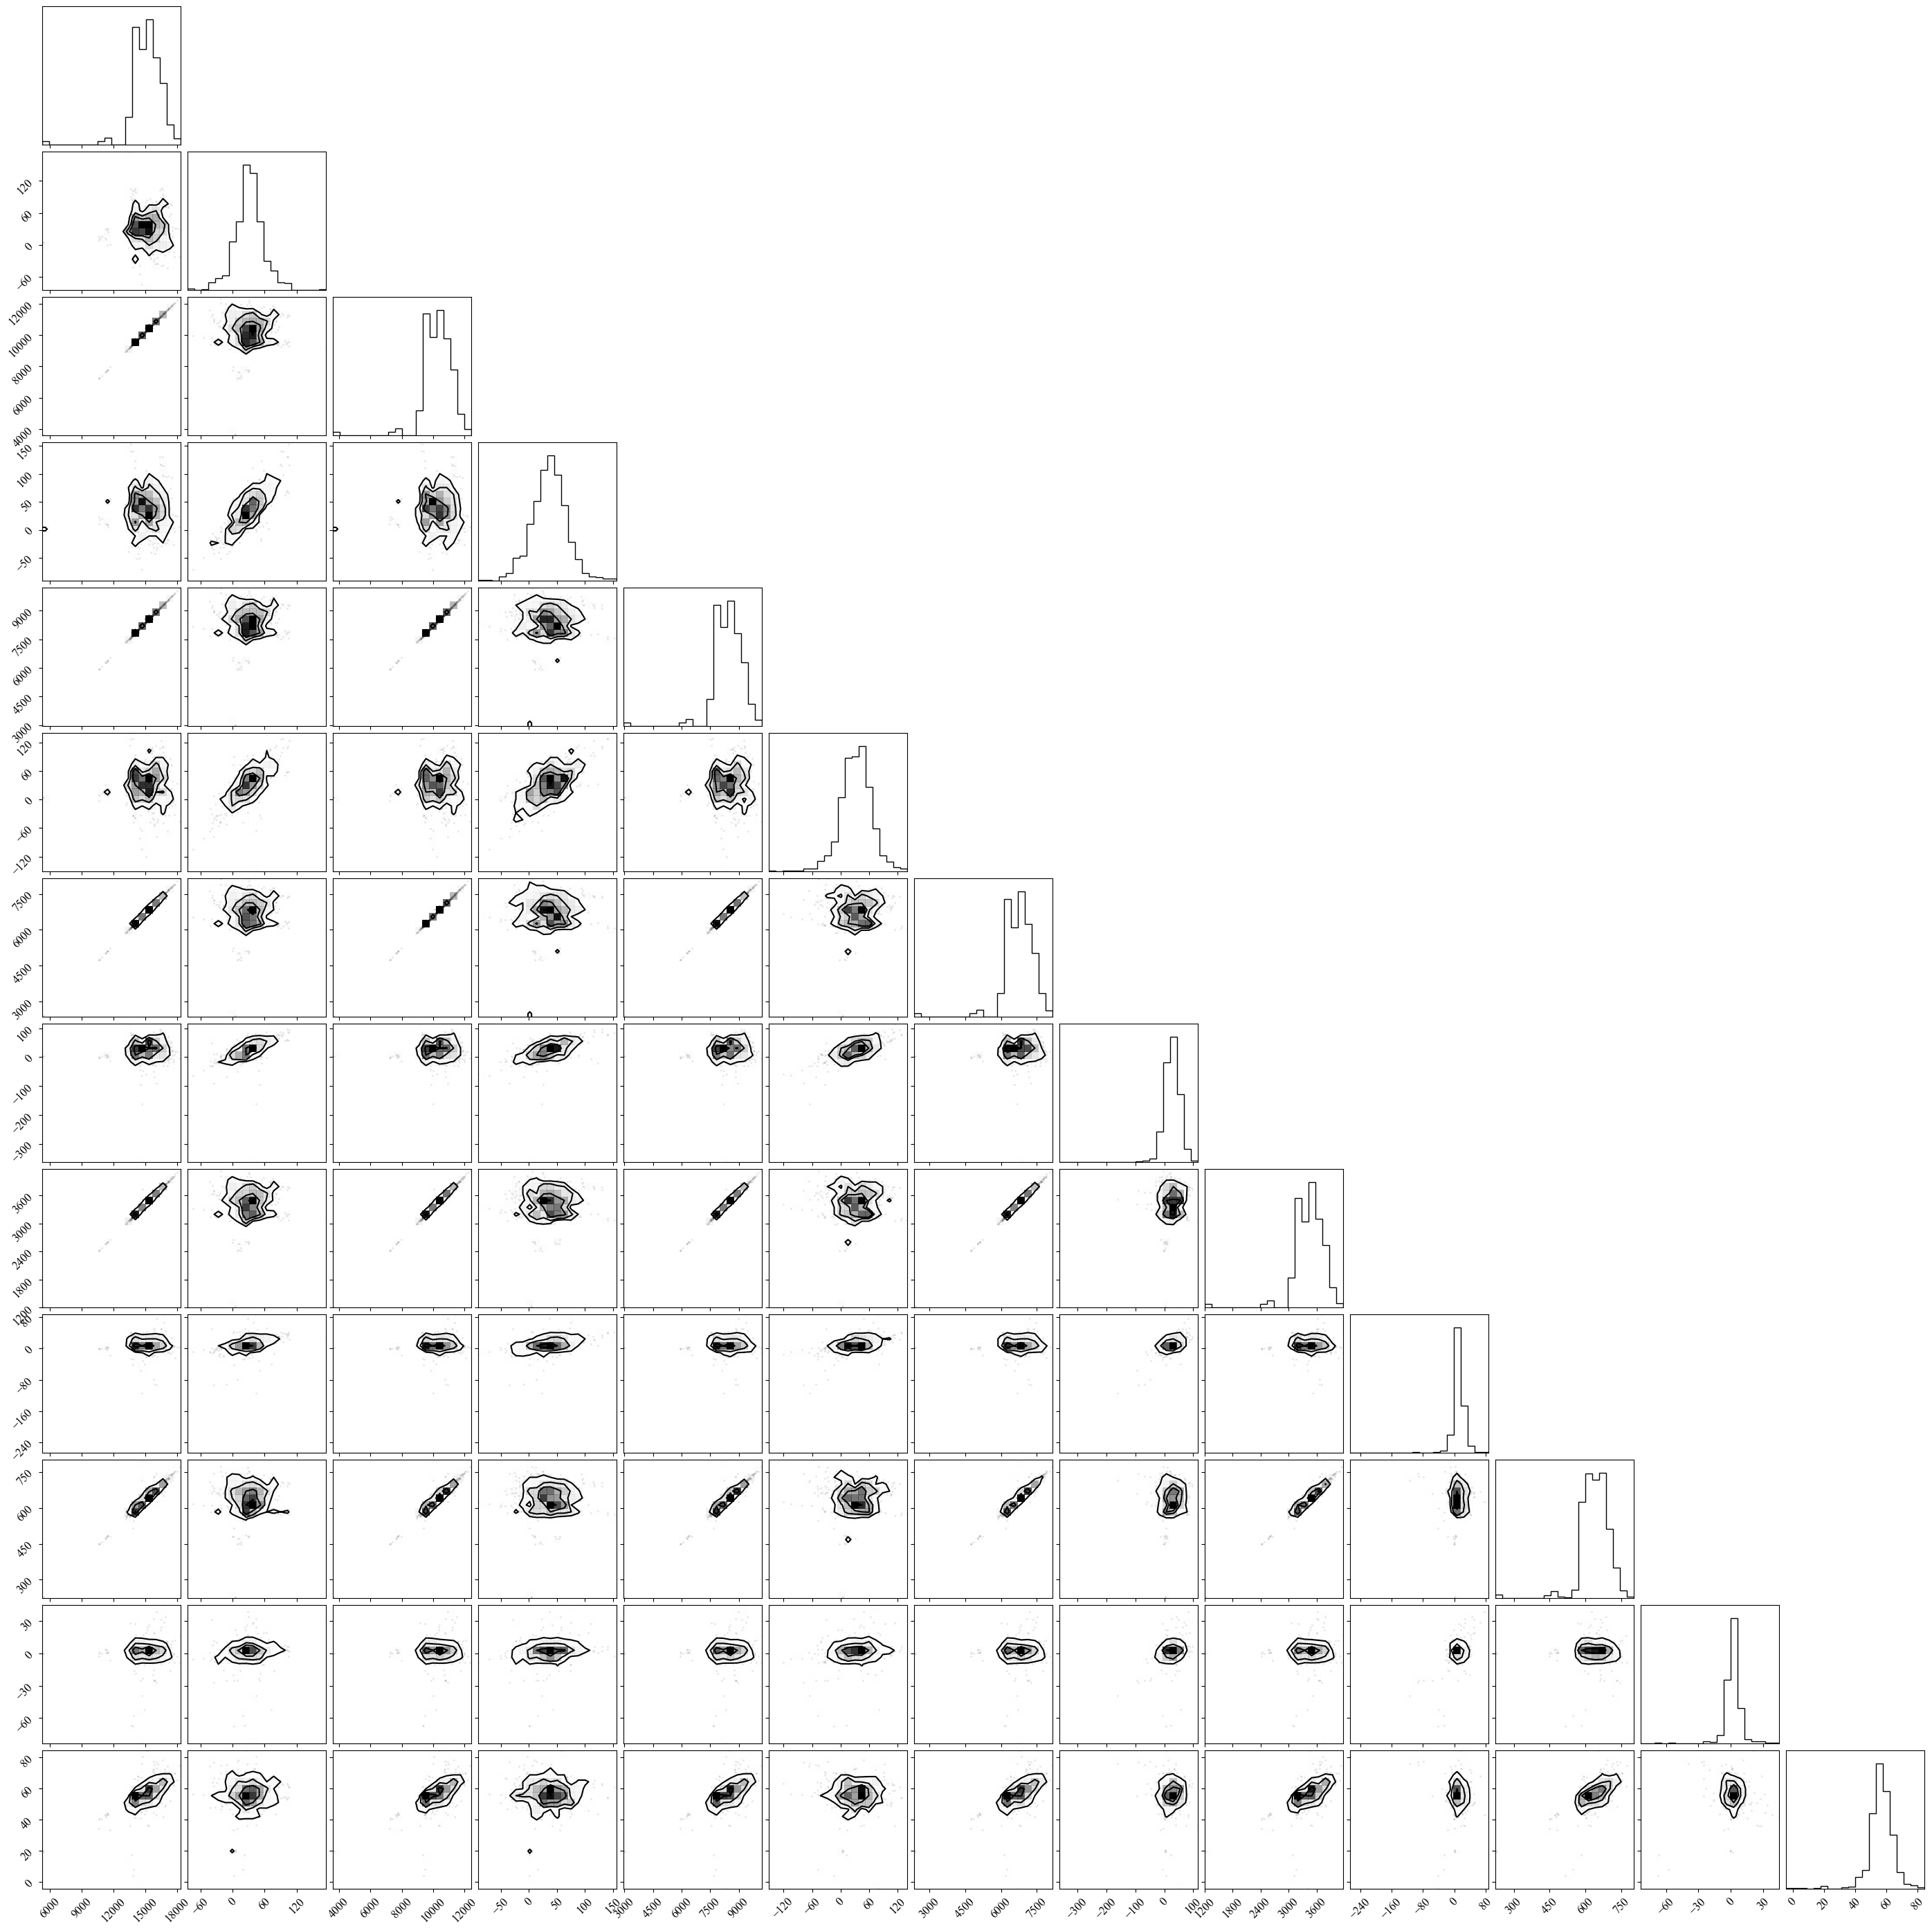

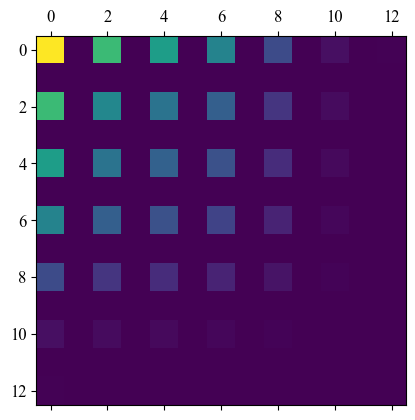

In [387]:
c0 = np.load('Data/p0_coefficients.npy')
c1 = np.load('Data/p1_coefficients.npy')
c2 = np.load('Data/p2_coefficients.npy')
c3 = np.load('Data/p3_coefficients.npy')
c4 = np.load('Data/p4_coefficients.npy')

samples = np.concatenate((c0, c1, c2, c3))
figure = corner.corner(samples)

coeff_cov = np.cov(samples.T)
fig, ax = plt.subplots()
ax.matshow(coeff_cov)

In [388]:
dt = st.mode(np.diff(time)).mode
smooth_time = np.arange(time.min(), time.max() + dt, dt)

padded_amp = np.full_like(smooth_time, np.nan, dtype=float)
indices = np.searchsorted(smooth_time, time)
padded_amp[indices] = amp

def rcos_diff(params, time, vis_amp):

    ##Constructing the joint model

    N_terms=13
    #Making our DPSS fit coefficients and emission parameters
    coeff = params[:N_terms]
    theta = params[N_terms:]
    
    #Constructing our DPSS basis
    NW, K = 4, N_terms
    design = dpss(len(time), NW, K).T
    background = design @ coeff

    #Building our emissions
    emission = np.zeros_like(time)
    if len(theta) > 0:
        num_emissions = len(theta) // 3
    else:
        num_emissions = 0

    if len(theta) % 3 != 0:
        raise ValueError("Incorrect array size for Gaussian fit parameters.")

    for k in range(num_emissions):
        amp, mu, sigma = theta[3*k : 3*k + 3]
        mask = np.abs(time - mu) <= sigma
        emission[mask] += amp / 2 * (1 + np.cos(np.pi*(time[mask] - mu)/sigma))

    #Defining the joint model
    amp_fit = background + emission

    #Defining our residuals
    mask = np.isfinite(vis_amp)
    mod_res = amp_fit[mask] - vis_amp[mask]
    
    #Constructing the noise:
    C = 4/np.pi - 1
    noise_var = (amp_fit[mask]**2) * C / (N_bl * N_freq) + 1e-5

    #Now we can build our log likelihood:
    log_like = -0.5 * (
        np.sum(mod_res**2 / noise_var) +  # Quadratic term
        np.sum(np.log(noise_var)) +         # Log determinant
        len(mod_res) * np.log(2*np.pi)    # Normalization
    )


    #Determining prior mean and covariance for DPSS coefficients
    prior_mean = np.mean(samples, axis=0)
    prior_cov = np.cov(samples.T)
    
    prior_residual = coeff - prior_mean
    
    
    # Full prior construction for coefficients
    L = la.cholesky(prior_cov, lower=True)
    alpha = la.solve_triangular(L, prior_residual, lower=True)
    log_prior_coeff = -0.5 * (
        alpha @ alpha +
        2 * np.sum(np.log(np.diag(L))) +
        N_terms * np.log(2*np.pi)
    )

    
    #Determining prior mean and covariance for emission coefficients
    emit_mean = np.mean(theta_0[[0, 2]], axis=1)
    emit_cov = la.block_diag(*[np.cov(theta_0[[0, 2]])] * num_emissions)

    mask = np.arange(len(theta)) % 3 != 1
    emit_residual = theta[mask] - np.tile(emit_mean, num_emissions)

    # Full prior construction for emission parameters
    L = la.cholesky(emit_cov, lower=True)
    alpha = la.solve_triangular(L, emit_residual, lower=True)
    log_prior_emit = -0.5 * (
        alpha @ alpha +
        2 * np.sum(np.log(np.diag(L))) +
        len(theta) * np.log(2*np.pi)
    )
    log_prior_emit=0
    
    print(-(log_like + log_prior_coeff + log_prior_emit))
    return -(log_like + log_prior_coeff + log_prior_emit)

In [397]:
from scipy.ndimage import label, center_of_mass

##Constructing masked fits
N_terms = 20
fit, coefficients, smooth_time, *cov = DPSS_fit(time, masked_time, masked_amp, 
                                                        N_win=4, N_terms=N_terms, N_bl=N_bl, N_freq=N_freq,
                                                        )
noise_err, param_err, fit_err = cov

print("Fit constructed.")


##Padding stuff
noise_err = np.diag(np.sqrt(noise_err))

padded_amp = np.full_like(smooth_time, np.nan, dtype=float)
indices = np.searchsorted(smooth_time, time)
padded_amp[indices] = amp

residuals = padded_amp - fit


##Filtering indices -- need to fix this
filt_ind = ~np.isnan(residuals)
smooth_time = smooth_time - np.min(smooth_time[np.isfinite(smooth_time)])

# Find regions above threshold
threshold = 20
mask = residuals > threshold * noise_err
labeled_mask, num_features = label(mask)  # Grouping contiguous regions

lengths = np.bincount(labeled_mask.flatten())[1:]

# Setting lower limit of 10 continguous points so that we know the emission is somewhat continuous.
emit_cands = np.where(lengths > 10, True, False) 
emit_cand_loc = np.where(emit_cands)[0] + 1
ind_com = np.array(center_of_mass(mask, labeled_mask, emit_cand_loc)).astype(int)

##Constructing the initial guesses -- emit_peaks being the amplitudes of the Gaussians, emit_com the means, emit_widths the STD.
emit_peaks = padded_amp[ind_com] - np.mean(padded_amp[filt_ind])
emit_com = smooth_time[ind_com]
emit_widths = []
for event in emit_cand_loc:
    indices = np.where(labeled_mask == event)[0]
    width = smooth_time[indices[-1]] - smooth_time[indices[0]]
    emit_widths.append(width)
emit_widths = np.array(emit_widths)

theta_init = np.stack((emit_peaks.flatten(), emit_com.flatten(), emit_widths)).T.flatten()
print(theta_init.shape)
print(coefficients.shape)
num_emissions = int(len(theta_init)/3)
print("Initial guess:", theta_init)
print("Number of emissions:", len(theta_init)/3)


p0 = np.concatenate((np.mean(samples, axis=0), theta_init))
print(p0.shape)
#p0 = np.concatenate((np.mean(samples, axis=0), np.tile(np.mean(theta_0, axis=1), num_emissions)))

Fit constructed.
(3,)
(20,)
Initial guess: [3.87732222e+01 8.61106440e-03 3.24072316e-04]
Number of emissions: 1.0
(16,)


In [399]:
N_terms=13
num_emissions = 1
smooth_time = smooth_time - np.min(smooth_time[np.isfinite(smooth_time)])

print("Initial guess:", p0)

bounds = (
    [(-1e5, 1e5)] * N_terms +
    ([(theta_0[0].min(), theta_0[0].max()), (0, smooth_time.max()), (theta_0[2].max()/3, theta_0[2].max())] * num_emissions)
)
print(bounds)
print(p0)


rcos_fit = minimize(
    lambda p: rcos_diff(p, smooth_time, padded_amp),
    x0=p0,
    bounds=bounds,
    method='Nelder-Mead',
    options={
        'maxiters': 50000,
        'maxfev': 50000,
        'adaptive': True,  
        'xatol': 1e-6,     
        'fatol': 1e-6
    }
).x

log_prob_min = rcos_diff(rcos_fit, smooth_time, padded_amp)
print(log_prob_min)
print(rcos_fit)

p0 = rcos_fit


Initial guess: [1.50330200e+04 2.38890440e+01 1.02553382e+04 2.87730516e+01
 8.38150446e+03 1.55576378e+01 6.76215570e+03 1.42872667e+01
 3.41552062e+03 3.14783422e+00 6.41299478e+02 1.42698951e+00
 4.99213858e+01 4.63017940e+01 8.40956323e-03 7.45573830e-04]
[(-100000.0, 100000.0), (-100000.0, 100000.0), (-100000.0, 100000.0), (-100000.0, 100000.0), (-100000.0, 100000.0), (-100000.0, 100000.0), (-100000.0, 100000.0), (-100000.0, 100000.0), (-100000.0, 100000.0), (-100000.0, 100000.0), (-100000.0, 100000.0), (-100000.0, 100000.0), (-100000.0, 100000.0), (np.float64(5.5279846), np.float64(85.09920858)), (0, np.float64(0.020879516378045082)), (np.float64(0.00037765323194444443), np.float64(0.0011329596958333332))]
[1.50330200e+04 2.38890440e+01 1.02553382e+04 2.87730516e+01
 8.38150446e+03 1.55576378e+01 6.76215570e+03 1.42872667e+01
 3.41552062e+03 3.14783422e+00 6.41299478e+02 1.42698951e+00
 4.99213858e+01 4.63017940e+01 8.40956323e-03 7.45573830e-04]
1323.0888429533807
1847542.719569

Unknown solver options: maxiters


179728.5324245246
84125.39042323695
139025.43927322872
71441.19640179844
121218.87372129766
62631.977938096075
118098.60051847731
62475.67851705535
88619.49684765842
47537.416365557765
102693.66197165393
50493.06412630613
74991.6113836483
39047.465968193086
72110.35014469216
38491.946677185
62408.72997133865
62386.71036994177
61502.75387292301
63613.99064874676
33016.61894910762
61742.72475663788
33071.32901851147
56824.88527220773
29160.162968243225
47212.616993446885
25239.574754860452
39160.98347997763
21014.737902956436
40482.61817773796
20822.09752216377
31499.107784623222
32334.875030731677
17625.77859860807
32892.78186598365
16937.77214602698
33224.30193036944
16493.07684366419
24881.85902361361
13757.471663874376
22351.953352747714
11523.944153823937
20317.46797858418
11222.753288148424
17616.330679193034
9886.699957405739
16400.78240743582
17025.576842555685
9582.95531169742
16881.97209138408
9236.533560262491
13947.58770066926
7891.7825821774895
11757.300901332763
6666.314962

[4.63017942e+01 8.40956323e-03 7.45573828e-04]


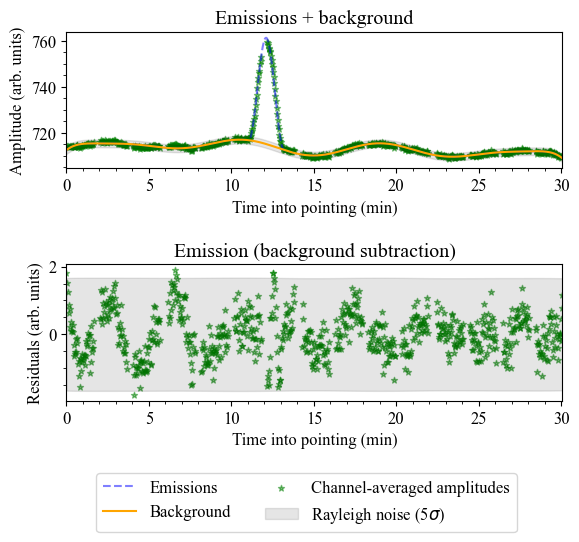

[1.50330200e+04 2.38890441e+01 1.02553382e+04 2.87730511e+01
 8.38150446e+03 1.55576371e+01 6.76215570e+03 1.42872672e+01
 3.41552062e+03 3.14783361e+00 6.41299477e+02 1.42698930e+00
 4.99213858e+01 4.63017942e+01 8.40956323e-03 7.45573828e-04]


In [400]:
def rcos_model(time, *params, show='all'):
    N_terms=13
    coeff = params[:N_terms]
    theta = params[N_terms:]
    
    NW, K = 4, N_terms   
    basis = dpss(len(time), NW, K)
    design = basis.T
    
    background = design @ coeff

    emission = np.zeros_like(time)
    num_emissions = len(theta) // 3

    if len(theta) % 3 != 0:
        raise ValueError("Incorrect array size for Gaussian fit parameters.")

    for k in range(num_emissions):
        amp, mu, sigma = theta[3*k : 3*k + 3]
        mask = np.where(np.abs(time - mu) <= sigma, True, False)
        emission[mask] += amp / 2 * (1 + np.cos(np.pi*(time[mask] - mu)/sigma))
        
    if show == 'all':
        return background + emission
    elif show == 'emit':
        return emission
    elif show == 'background':
        return background

print(rcos_fit[N_terms:])
plt.style.use('default')
plt.rcParams.update({'font.size': 12,
                     'font.family': 'serif',
                     'font.serif': 'Times New Roman'})

figure, ax = plt.subplots(ncols=1, nrows=2)
ax[0].set_title("Emissions + background")
ax[0].plot(smooth_time*60*24, rcos_model(smooth_time, *rcos_fit), color='blue', alpha=0.5, linestyle='--', label='Emissions')
ax[0].plot(smooth_time*60*24, rcos_model(smooth_time, *rcos_fit, show='background'), color='orange', alpha=1, label = 'Background')
ax[0].set_xlabel("Time into pointing (min)")
ax[0].set_ylabel("Amplitude (arb. units)")
ax[0].scatter(smooth_time*60*24, padded_amp, s=20, alpha=0.5, color='green', label='Channel-averaged amplitudes', marker='*')
ax[0].fill_between(smooth_time*60*24, 
                 -5*np.sqrt((4/np.pi-1)/N_bl/N_freq)*rcos_model(smooth_time, *rcos_fit, show='background') + rcos_model(smooth_time, *rcos_fit, show='background'),
                 5*np.sqrt((4/np.pi-1)/N_bl/N_freq)*rcos_model(smooth_time, *rcos_fit, show='background') + rcos_model(smooth_time, *rcos_fit, show='background'),
                 alpha = 0.1, color = 'black', label = r'Rayleigh noise (5$\sigma$)')
ax[0].set_xlim(smooth_time.min()*60*24, smooth_time.max()*60*24)
figure.legend(bbox_to_anchor=(0.5, -0.18), loc = 'lower center', ncol=2)
plt.subplots_adjust(hspace=0.7)

ax[1].set_title('Emission (background subtraction)')
ax[1].set_xlabel("Time into pointing (min)")
#ax[1].plot(smooth_time*60*24, rcos_model(smooth_time, *rcos_fit, show='emit'), color='blue', alpha=0.5, label = 'Emissions', linestyle='--')
ax[1].set_ylabel("Residuals (arb. units)")
ax[1].scatter(smooth_time*60*24, padded_amp - rcos_model(smooth_time, *rcos_fit, show='all'), s=20, alpha=0.5, color='green', label='Residuals', marker='*')
ax[1].fill_between(smooth_time*60*24, 
                 -5*np.sqrt((4/np.pi-1)/N_bl/N_freq)*rcos_model(smooth_time, *rcos_fit, show='background'),
                 5*np.sqrt((4/np.pi-1)/N_bl/N_freq)*rcos_model(smooth_time, *rcos_fit, show='background'),
                 alpha = 0.1, color = 'black', label = r'Rayleigh noise (5$\sigma$)')
ax[1].set_xlim(smooth_time.min()*60*24, smooth_time.max()*60*24)

ax[0].minorticks_on()
ax[1].minorticks_on()
plt.show()

print(rcos_fit)

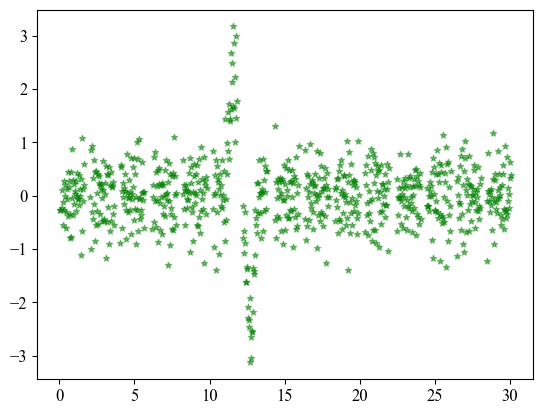

In [401]:
plt.scatter(smooth_time[1:]*60*24, np.diff(padded_amp - rcos_model(smooth_time, *rcos_fit, show='background')), s=20, alpha=0.5, color='green', label='Differences', marker='*')
#plt.scatter(smooth_time*60*24, padded_amp, s=20, alpha=0.5, color='green', label='Channel-averaged amplitudes', marker='*')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


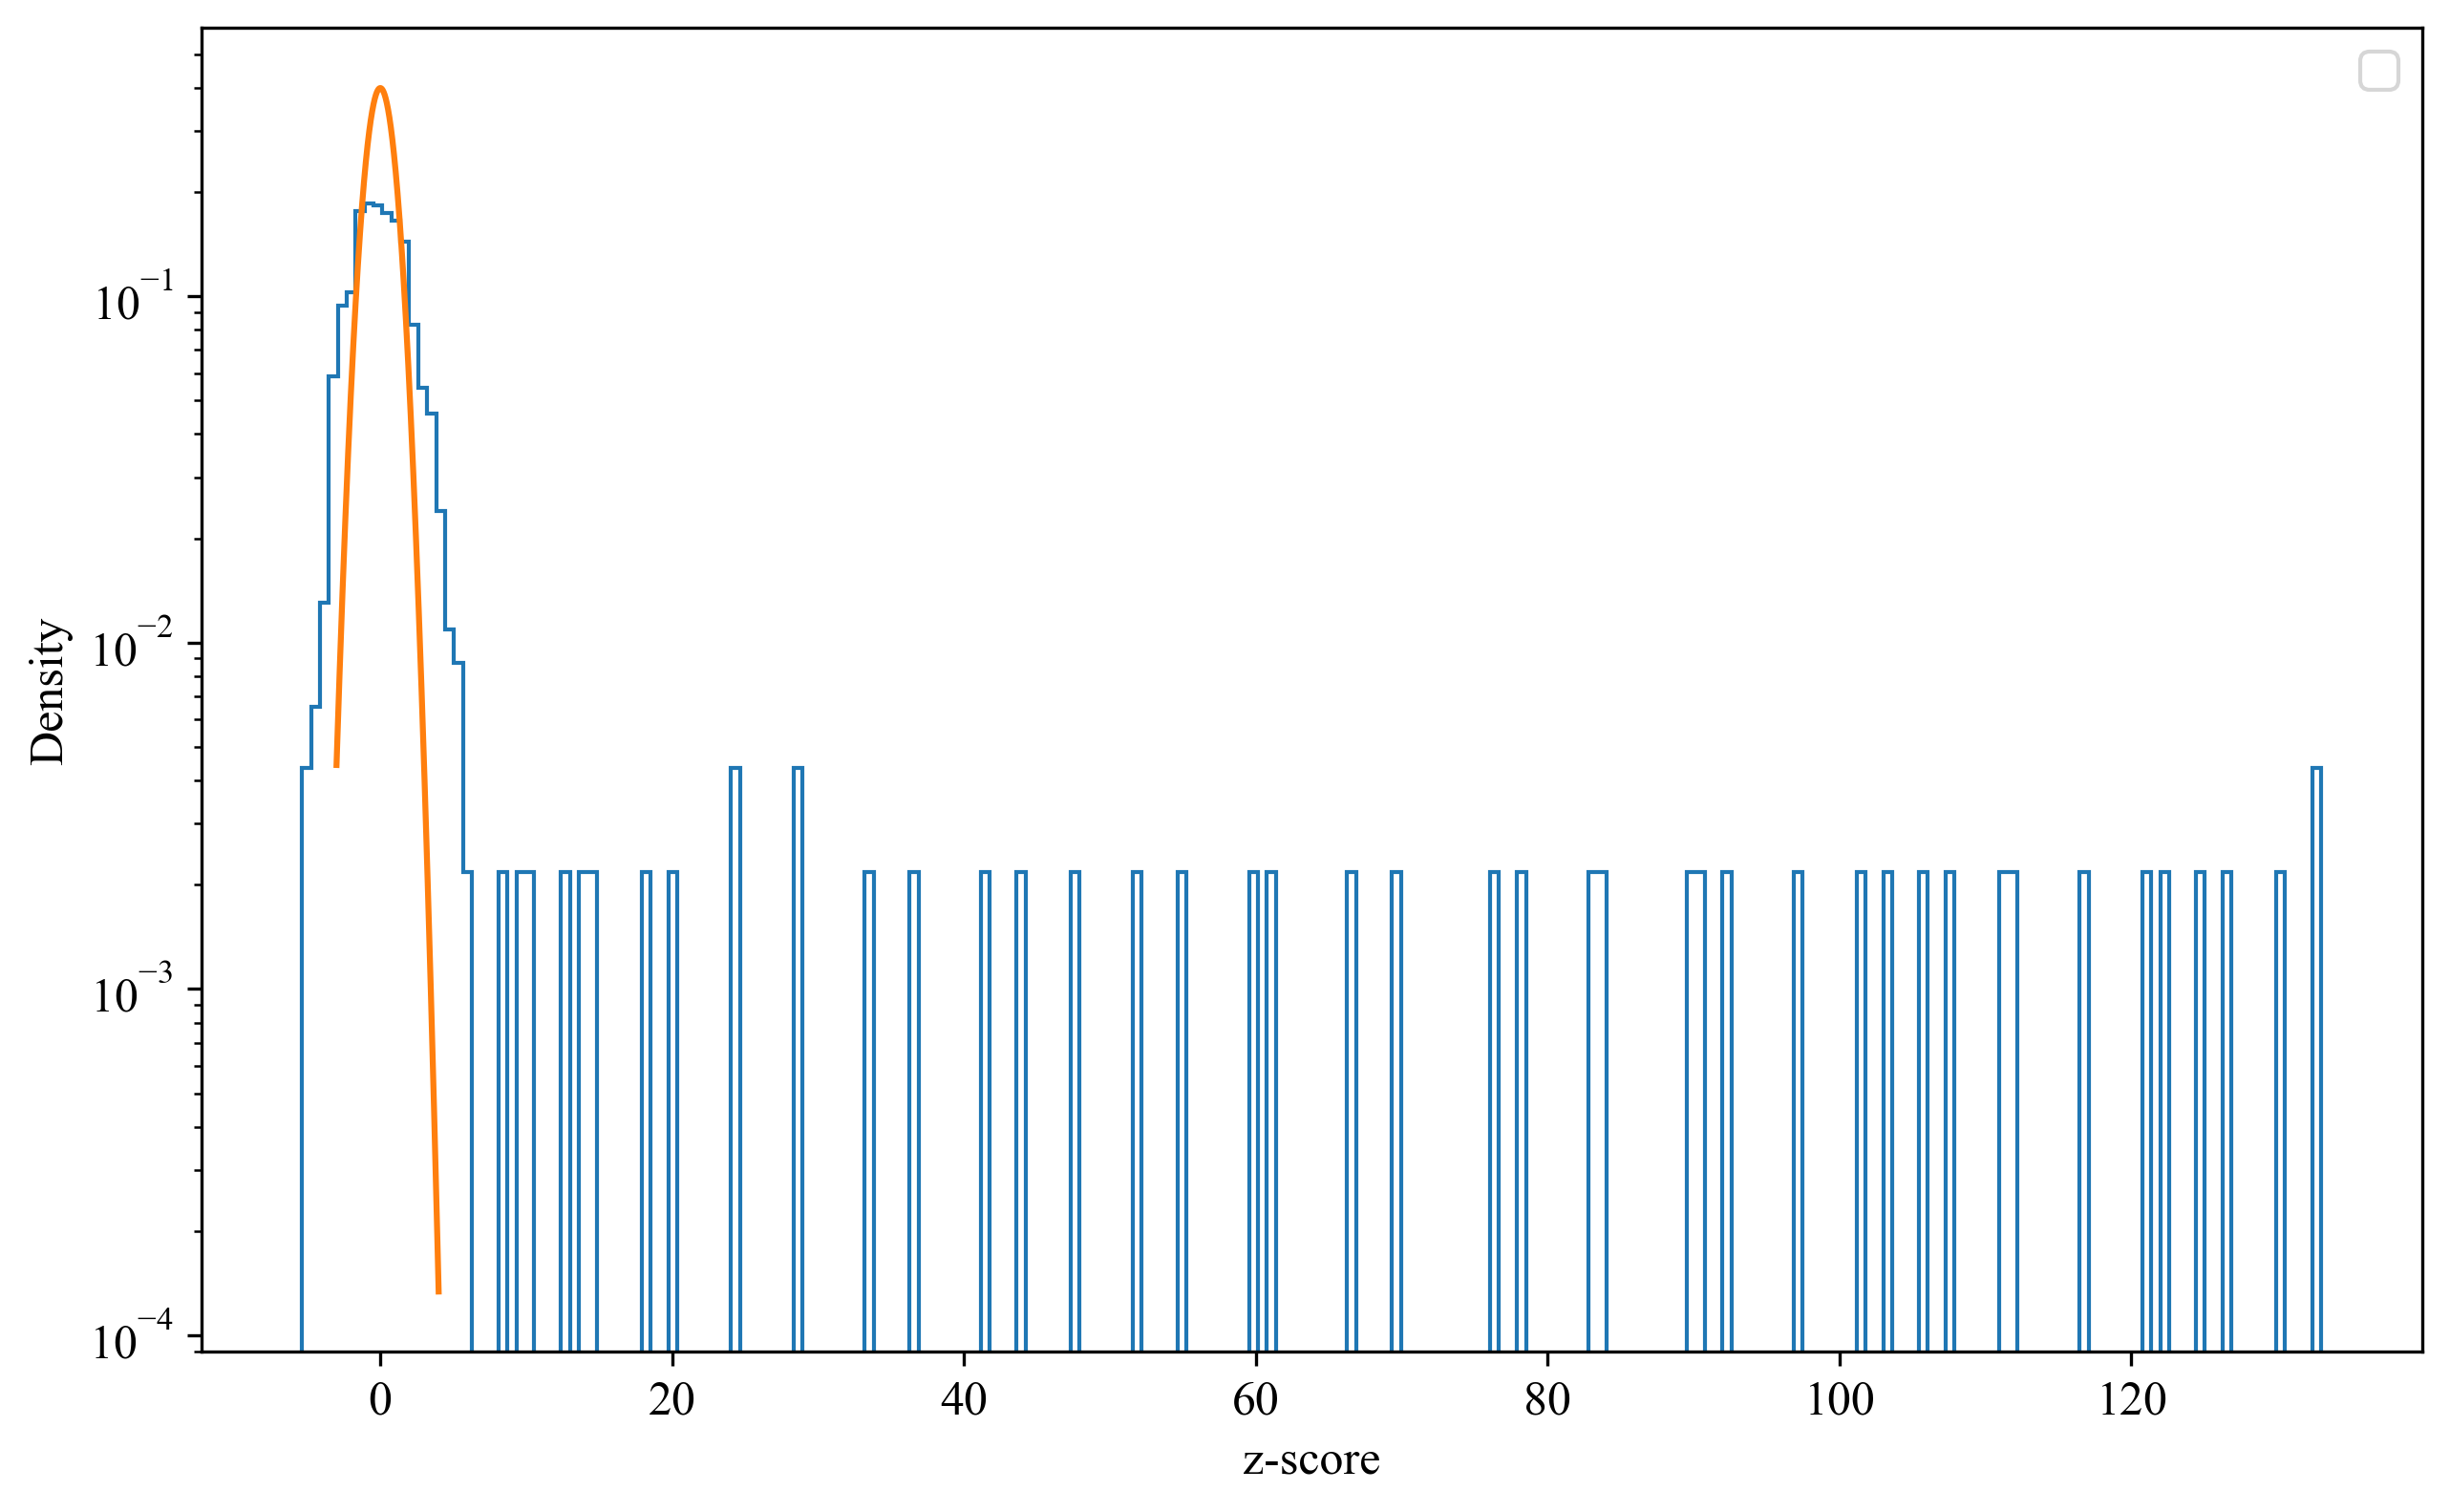

In [402]:
z_scores = (padded_amp - rcos_model(smooth_time, *rcos_fit, show='background'))/(np.sqrt((4/np.pi-1)/N_bl/N_freq)*rcos_model(smooth_time, *rcos_fit, show='background'))
z_scores = z_scores[np.isfinite(z_scores)]

x = np.linspace(-3, 4, 1000)


plt.figure(figsize=(10, 6), dpi=300)
plt.xlabel("z-score")
#plt.plot(smooth_time*60*24, rcos_model(smooth_time, *rcos_fit, show='emit'), color='orange', alpha=1, label = 'Emissions')
plt.ylabel("Density")
plt.hist(z_scores, bins='auto', histtype='step', density=True)
plt.plot(x, np.exp(-x**2/2)/np.sqrt(2*np.pi))
plt.yscale('log')
plt.legend()
plt.show()